In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## Get Modified Dataset for Training

In [2]:

# Loading feather files
if True:
    Combined_Feature_train_df = pd.read_feather('Garbage_data/Combined_Feature_train.feather')
    Combined_Feature_val_df = pd.read_feather('Garbage_data/Combined_Feature_val.feather')

In [3]:
if True:
    # Combine train and validation set for cross validation tests

    Full_df = pd.concat((Combined_Feature_train_df, Combined_Feature_val_df), axis=0)
    X_train = Full_df.iloc[:, :-1].values
    y_train = Full_df['label'].values
else:
    # seperate training and validation dataframes between features and labels for manual training

    X_train = Combined_Feature_train_df.iloc[:, :-1].values
    X_val = Combined_Feature_val_df.iloc[:, :-1].values

    y_train = Combined_Feature_train_df['label'].values
    y_val = Combined_Feature_val_df['label'].values

## Pipeline

In [4]:
scaler = StandardScaler()
validation_scores = {}

In [5]:
# SVM pipeline using one-vs-one organization to do multi-class classification
SVM_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('svc', svm.SVC(kernel='rbf', decision_function_shape='ovo', C=0.5))])

In [6]:
# performs cross validation with our just our training set

train_sizes, train_scores, val_scores = learning_curve(
    SVM_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

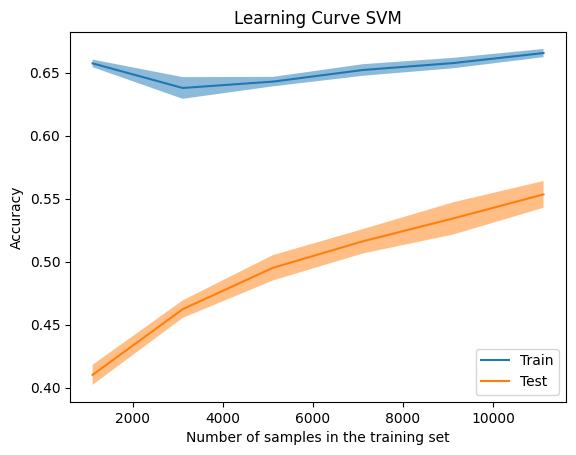

In [7]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)

disp.plot()
plt.title("Learning Curve SVM")
plt.show()

In [8]:
validation_scores['SVM'] = val_scores
val_scores

array([[0.40453074, 0.39964029, 0.42302158, 0.41330935, 0.40971223],
       [0.45487235, 0.46007194, 0.47482014, 0.45755396, 0.46366906],
       [0.48435814, 0.48489209, 0.50935252, 0.49280576, 0.50395683],
       [0.50737145, 0.51223022, 0.53201439, 0.50683453, 0.52230216],
       [0.51995685, 0.53561151, 0.55143885, 0.51978417, 0.54460432],
       [0.53901474, 0.55647482, 0.56546763, 0.54280576, 0.56294964]])

In [9]:
# RandomForest pipeline
RF_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('rf', RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=8))])

In [10]:
# performs cross validation using RandomForest Estimator


train_sizes, train_scores, val_scores = learning_curve(
    RF_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

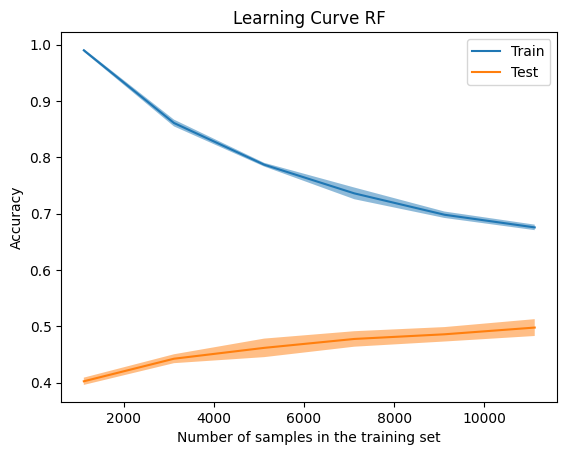

In [11]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)


disp.plot()
plt.title("Learning Curve RF")
plt.show()


In [12]:
validation_scores['RF'] = val_scores
val_scores

array([[0.38978785, 0.40467626, 0.40539568, 0.40359712, 0.40827338],
       [0.44084862, 0.43201439, 0.45647482, 0.44028777, 0.44244604],
       [0.45702985, 0.43453237, 0.4852518 , 0.46402878, 0.4676259 ],
       [0.48148148, 0.45395683, 0.49280576, 0.47158273, 0.48776978],
       [0.48507731, 0.46942446, 0.49676259, 0.47446043, 0.50323741],
       [0.49478605, 0.47625899, 0.50899281, 0.48956835, 0.51906475]])

## Confidence Interval

In [13]:
sample_sizes = np.linspace(0.1, 1.0, 6)


In [14]:
# Hard code t score from table for 95% confidence
t_score = 2.776


SVM_mean = validation_scores['SVM'].mean(axis=1)
RF_mean = validation_scores['RF'].mean(axis=1)

SVM_std = validation_scores['SVM'].std(ddof=1, axis=1)
RF_std = validation_scores['RF'].std(ddof=1, axis=1)

In [15]:
# Compute the confidence interval
def confidence_interval(mean, std, k, crit_val):
    
    lower = mean - (crit_val * (std/(k**0.5)))
    upper = mean + (crit_val * (std/(k**0.5)))

    return np.array([lower, upper])

In [16]:
for mean, std, sample_size in zip(SVM_mean, SVM_std, sample_sizes):
    SVM_range = confidence_interval(mean = mean, std = std, k =5, crit_val=t_score)
    print(f'Confidence Interval for SVM model with sample size {sample_size:0.2f} and 95% confidence is {SVM_range[0]*100:0.2f}% - {SVM_range[1]*100:0.2f}%')


Confidence Interval for SVM model with sample size 0.10 and 95% confidence is 39.90% - 42.11%
Confidence Interval for SVM model with sample size 0.28 and 95% confidence is 45.26% - 47.18%
Confidence Interval for SVM model with sample size 0.46 and 95% confidence is 48.11% - 50.90%
Confidence Interval for SVM model with sample size 0.64 and 95% confidence is 50.27% - 52.96%
Confidence Interval for SVM model with sample size 0.82 and 95% confidence is 51.65% - 55.20%
Confidence Interval for SVM model with sample size 1.00 and 95% confidence is 53.86% - 56.81%


In [17]:
for mean, std, sample_size in zip(RF_mean, RF_std, sample_sizes):

    RF_range = confidence_interval(mean=mean, std=std, k=5, crit_val=t_score)
    print(f'Confidence Interval for RF model with sample size {sample_size:0.2f} and 95% confidence is {RF_range[0]*100:0.2f}% - {RF_range[1]*100:0.2f}%')


Confidence Interval for RF model with sample size 0.10 and 95% confidence is 39.34% - 41.13%
Confidence Interval for RF model with sample size 0.28 and 95% confidence is 43.14% - 45.34%
Confidence Interval for RF model with sample size 0.46 and 95% confidence is 43.88% - 48.45%
Confidence Interval for RF model with sample size 0.64 and 95% confidence is 45.84% - 49.66%
Confidence Interval for RF model with sample size 0.82 and 95% confidence is 46.80% - 50.36%
Confidence Interval for RF model with sample size 1.00 and 95% confidence is 47.70% - 51.85%
